In [5]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import shap
import xgboost as xgb
from sklearn.metrics import auc, roc_curve

from scripts.utils import objective_xgboost, bootstrap_test, create_balanced_cv

optuna.logging.set_verbosity(optuna.logging.WARNING)

In [6]:
SIGNAL_FEATURE = ['mbp', 'sbp', 'dbp', 'hr', 'rr', 'spo2', 'etco2', 'mac', 'pp_ct']
STATIC_FEATURE = ["age", "bmi", "asa", "preop_cr", "preop_htn"]
HALF_TIME_FILTERING = [10, 60, 60*5]

FEATURE_NAME = (
    [
        f"{signal}_ema_{half_time}"
        for signal in SIGNAL_FEATURE
        for half_time in HALF_TIME_FILTERING
    ]
    + [
        f"{signal}_std_{half_time}"
        for signal in SIGNAL_FEATURE
        for half_time in HALF_TIME_FILTERING
    ]
    + STATIC_FEATURE
)

BASELINE_FEATURE_NAME = 'mbp_ema_10'

## Load and format data

In [7]:
# import the data frame and add the meta data to the segments
data = pd.read_parquet(Path('data/datasets/base_dataset_no_leading_time/cases/'))

static = pd.read_parquet('data/datasets/base_dataset_no_leading_time/meta.parquet')

data = data.merge(static, on='caseid')

data.asa = data.asa.astype(int)
data.preop_htn = data.preop_htn.astype(int)



## Train or load existing model


In [18]:
# control reproducibility
rng_seed = 42

result_folder = Path("data/results")
if not result_folder.exists():
    result_folder.exists()

for leading_time in range(0,7,2):
    data_lead = data[(data.time_before_IOH >= leading_time*60) | (data.time_before_IOH.isna())]

    train = data_lead[data_lead['split'] == "train"]
    test = data_lead[data_lead['split'] == "test"]

    # train_case_label = train.groupby("caseid").agg(
    #             segment_count=("label", "count"),
    #             label_count=("label", "sum"),
    #         )

    # train_cv_split = create_balanced_cv(train_case_label, nb_max_iter=100000)


    
    train = train.dropna(subset=FEATURE_NAME)
    test = test.dropna(subset=FEATURE_NAME)
    print('leading time:', leading_time)
    print(
        f'{len(train)} train samples and {len(test)} test samples, positive rate = {test["label"].mean():.2f}'
    )

    # Set model file, create models folder if does not exist.
    model_folder = Path("data/models")
    if not model_folder.exists():
        model_folder.mkdir()
    model_file = model_folder / f"xgb.json"

    # create a regressor
    if model_file.exists():
        model = xgb.XGBClassifier()
        model.load_model(model_file)
    else:
        # creat an optuna study
        study = optuna.create_study(direction="maximize")
        study.optimize(
            lambda trial: objective_xgboost(trial, train, FEATURE_NAME, train_cv_split),
            n_trials=80,
            show_progress_bar=True,
        )

        # get the best hyperparameters
        best_params = study.best_params

        model = xgb.XGBClassifier(**best_params)
        # refit the model with best parameters
        model.fit(train[FEATURE_NAME], train.label, verbose=1)

        # save the model
        model.save_model(model_file)

    # test the model
    y_pred = model.predict_proba(test[FEATURE_NAME])[:, 1]
    y_test = test["label"].values
    y_label_id = test["label_id"].values

    df_results, _ = bootstrap_test(y_test, y_pred, y_label_id, n_bootstraps=200, rng_seed=rng_seed)
    
    # roc_results = result_folder / f"xgboost_roc_lead_{leading_time}.csv"
    # df_results.to_csv(roc_results, index=False)

    #test baseline
    # y_pred_baseline = 1 - test[BASELINE_FEATURE_NAME].values/120

    # df_results_baseline, _ = bootstrap_test(y_test, y_pred_baseline, y_label_id, n_bootstraps=200, rng_seed=rng_seed)

    # roc_results = result_folder / f"baseline_roc_lead_{leading_time}.csv"
    # df_results_baseline.to_csv(roc_results, index=False)




leading time: 0
105753 train samples and 40545 test samples, positive rate = 0.07
leading time: 2
104142 train samples and 39882 test samples, positive rate = 0.06


invalid value encountered in cast


leading time: 4
102618 train samples and 39257 test samples, positive rate = 0.04


invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast


leading time: 6
101177 train samples and 38704 test samples, positive rate = 0.03


invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value 

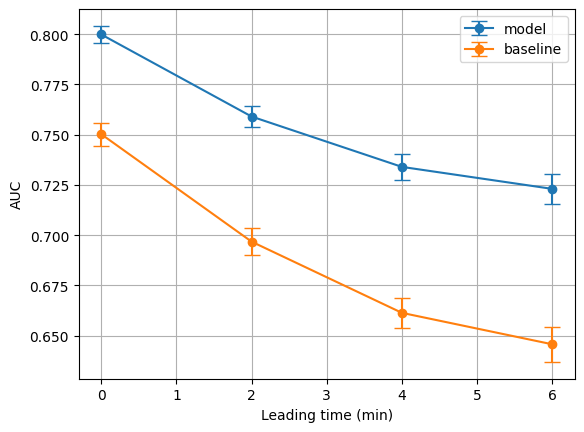

In [16]:
xgboost_auc_list, baseline_auc_list, lead_time_list = [], [], []
xgboost_auc_std_list, baseline_auc_std_list = [], []

for leading_time in range(0,7,2):
    lead_time_list.append(leading_time)
    roc_results = result_folder / f"xgboost_roc_lead_{leading_time}.csv"
    df_results = pd.read_csv(roc_results)
    xgboost_auc_list.append(df_results.auc[0])
    xgboost_auc_std_list.append(df_results.auc_std[0])

    roc_results = result_folder / f"baseline_roc_lead_{leading_time}.csv"
    df_results = pd.read_csv(roc_results)
    baseline_auc_list.append(df_results.auc[0])
    baseline_auc_std_list.append(df_results.auc_std[0])
    

plt.errorbar(lead_time_list, xgboost_auc_list,xgboost_auc_std_list, fmt='-o', label='model', capsize=6)
plt.errorbar(lead_time_list, baseline_auc_list, baseline_auc_std_list, fmt='-o', label='baseline', capsize=6)
plt.xlabel('Leading time (min)')
plt.ylabel('AUC')
plt.grid()
plt.legend()
plt.show()

#save the data
auc_df = pd.DataFrame({'lead_time': lead_time_list, 'xgboost_auc': xgboost_auc_list, 'xgboost_auc_std': xgboost_auc_std_list, 'baseline_auc': baseline_auc_list, 'baseline_auc_std': baseline_auc_std_list})
auc_df.to_csv(result_folder / 'auc_lead_time.csv', index=False)

In [10]:
# control reproducibility
rng_seed = 42

result_folder = Path("data/results")
if not result_folder.exists():
    result_folder.exists()

for leading_time in range(0,7,2):
    data_lead = data[(data.time_before_IOH >= leading_time*60) | (data.time_before_IOH.isna())]

    train = data_lead[data_lead['split'] == "train"]
    test = data_lead[data_lead['split'] == "test"]

    train_case_label = train.groupby("caseid").agg(
                segment_count=("label", "count"),
                label_count=("label", "sum"),
            )

    # train_cv_split = create_balanced_cv(train_case_label, nb_max_iter=100000)


    
    train = train.dropna(subset=FEATURE_NAME)
    test = test.dropna(subset=FEATURE_NAME)
    print('leading time:', leading_time)
    print(
        f'{len(train)} train samples and {len(test)} test samples, positive rate = {test["label"].mean():.2f}'
    )

    # Set model file, create models folder if does not exist.
    model_folder = Path("data/models")
    if not model_folder.exists():
        model_folder.mkdir()
    model_file = model_folder / f"xgb_lead_{0}.json"

    # create a regressor
    if model_file.exists():
        model = xgb.XGBClassifier()
        model.load_model(model_file)
    else:
        # creat an optuna study
        study = optuna.create_study(direction="maximize")
        study.optimize(
            lambda trial: objective_xgboost(trial, train, FEATURE_NAME, train_cv_split),
            n_trials=80,
            show_progress_bar=True,
        )

        # get the best hyperparameters
        best_params = study.best_params

        model = xgb.XGBClassifier(**best_params)
        # refit the model with best parameters
        model.fit(train[FEATURE_NAME], train.label, verbose=1)

        # save the model
        model.save_model(model_file)

    # test the model
    y_pred = model.predict_proba(test[FEATURE_NAME])[:, 1]
    y_test = test["label"].values
    y_label_id = test["label_id"].values

    df_results, _ = bootstrap_test(y_test, y_pred, y_label_id, n_bootstraps=200, rng_seed=rng_seed)
    
    roc_results = result_folder / f"xgboost_roc_lead_{leading_time}.csv"
    df_results.to_csv(roc_results, index=False)

    #test baseline
    y_pred_baseline = 1 - test[BASELINE_FEATURE_NAME].values/120

    df_results_baseline, _ = bootstrap_test(y_test, y_pred_baseline, y_label_id, n_bootstraps=200, rng_seed=rng_seed)

    roc_results = result_folder / f"baseline_roc_lead_{leading_time}.csv"
    df_results_baseline.to_csv(roc_results, index=False)



leading time: 0
105753 train samples and 40545 test samples, positive rate = 0.07


invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value 

leading time: 2
104142 train samples and 39882 test samples, positive rate = 0.06


invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value 

leading time: 4
102618 train samples and 39257 test samples, positive rate = 0.04


invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value 

leading time: 6
101177 train samples and 38704 test samples, positive rate = 0.03


invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value encountered in cast
invalid value 

## Plot

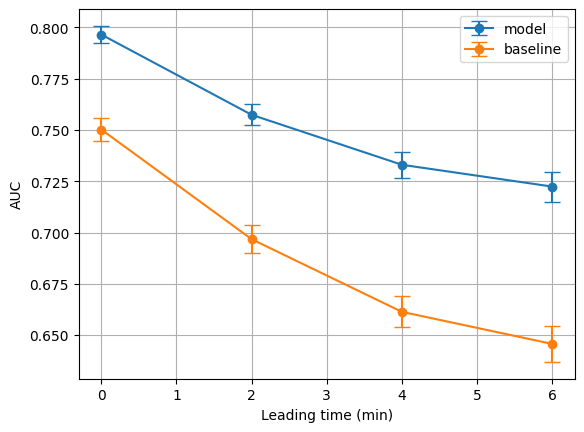

In [11]:
xgboost_auc_list, baseline_auc_list, lead_time_list = [], [], []
xgboost_auc_std_list, baseline_auc_std_list = [], []

for leading_time in range(0,7,2):
    lead_time_list.append(leading_time)
    roc_results = result_folder / f"xgboost_roc_lead_{leading_time}.csv"
    df_results = pd.read_csv(roc_results)
    xgboost_auc_list.append(df_results.auc[0])
    xgboost_auc_std_list.append(df_results.auc_std[0])

    roc_results = result_folder / f"baseline_roc_lead_{leading_time}.csv"
    df_results = pd.read_csv(roc_results)
    baseline_auc_list.append(df_results.auc[0])
    baseline_auc_std_list.append(df_results.auc_std[0])
    

plt.errorbar(lead_time_list, xgboost_auc_list,xgboost_auc_std_list, fmt='-o', label='model', capsize=6)
plt.errorbar(lead_time_list, baseline_auc_list, baseline_auc_std_list, fmt='-o', label='baseline', capsize=6)
plt.xlabel('Leading time (min)')
plt.ylabel('AUC')
plt.grid()
plt.legend()
plt.show()

#save the data
auc_df = pd.DataFrame({'lead_time': lead_time_list, 'xgboost_auc': xgboost_auc_list, 'xgboost_auc_std': xgboost_auc_std_list, 'baseline_auc': baseline_auc_list, 'baseline_auc_std': baseline_auc_std_list})
auc_df.to_csv(result_folder / 'auc_lead_time.csv', index=False)

In [12]:
xgboost_auc_std_list

[0.0042114137195933, 0.0051889695851312, 0.006460487272984, 0.0072909622208437]